# Vanilla GAN 실습

In [0]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision # 이미지 관련 처리, Pretrained Model 관련된 Package 입니다.
import torchvision.transforms as T # 이미지 처리 (Vison) 관련된 transformation이 정의 되어 있습니다.
import torchvision.datasets as datasets
import torch.optim as optim # pytorch 에서 정의한 수 많은 optimization function 들이 들어 있습니다.
from torch.autograd import Variable
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

In [0]:
# MNIST Vanilla GAN

In [0]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

## Data Loader 불러오기

In [0]:
def MNIST_DATA(root='./data/', train =True, transforms=None, download =True, batch_size=100, num_worker=1):
    print ("[+] Get the MNIST DATA")
    """
    torchvision.dataset 에는 우리가 많이 사용하는 데이터들을 쉽게 사용할 수 있도록 되어 있습니다. 
    Machine Learning 에서 Hello world 라고 불리는 Mnist 데이터를 사용해 보겠습니다.
  
    """
    transform = T.? # 얻어낸 데이터를 pytorch가 계산 할 수 있는 Tensor 로 변환해 줍니다. 
    
    mnist_train = datasets.MNIST(root = root,  #root 는 데이터의 저장 위치 입니다. 
                                 train = True, #Train 은 이 데이터가 train 데이터인지 아닌지에 대한 정보입니다. 
                                 transform = transform,
                                 download = True)  # 데이터를 다운로드 할지 여부를 물어봅니다. 
    mnist_test = datasets.MNIST(root = root,
                                train = False,  # Test Data를 가져오기에 Train =False 를 줘야 합니다. 
                                transform = transform,
                                download = True)
    """
    Data Loader 는 데이터와 batch size의 정보를 바탕으로 매 iteration 마다 주어진 데이터를 원하는 batch size 만큼 반환해주는 iterator입니다. 
    * Practical Guide : Batch size 는 어느정도가 좋나요? -- 클 수록 좋다는 소리가 있습니다. 하지만 gpu memeory 사이즈 한계에 의해 기본적으로 batch size 가 
    커질 수록 학습에 사용되는 gpu memory 사이즈가 큽니다. (Activation map을 저장해야 하기 때문입니다.) 기본적으로 2의 배수로 저장하는 것이 좋습니다.(Bit size 관련) 
    """
    trainDataLoader = data.DataLoader(dataset = mnist_train,  # DataSet은 어떤 Data를 제공해 줄지에 대한 정보입니다. 여기서는 Training DATA를 제공합니다. 
                                      batch_size = batch_size, # batch size 정보를 꼭 줘야 합니다. 한 Batch 당 몇 개의 Data 를 제공할지에 대한 정보입니다. 
                                      shuffle = True, # Training의 경우 Shuffling 을 해주는 것이 성능에 지대한 영향을 끼칩니다. 꼭 True 를 줘야 합니다. 
                                      num_workers = num_worker) # num worker의 경우 데이터를 로드하는데 worker를 얼마나 추가하겠는가에 대한 정보입니다. 

    testDataLoader = data.DataLoader(dataset = mnist_test, # Test Data Loader 이므로 Test Data를 인자로 전달해줍니다.
                                     batch_size = batch_size, # 마찬가지로 Batch size 를 넣어줍니다. 
                                     shuffle = False, # shuffling 이 굳이 필요하지 않으므로 false를 줍니다. 
                                     num_workers = num_worker) #
    print ("[+] Finished loading data & Preprocessing")
    return mnist_train, mnist_test, trainDataLoader, testDataLoader

In [0]:
trainDset, testDset, trainDataLoader, testDataLoader = MNIST_DATA(batch_size=100, num_worker=4)  # Data Loader 를 불러 옵니다. 

[+] Get the MNIST DATA
[+] Finished loading data & Preprocessing


## MNIST Data 확인

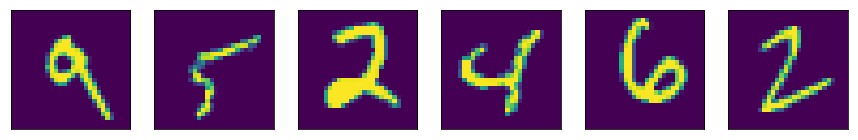

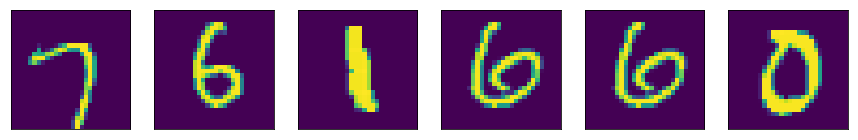

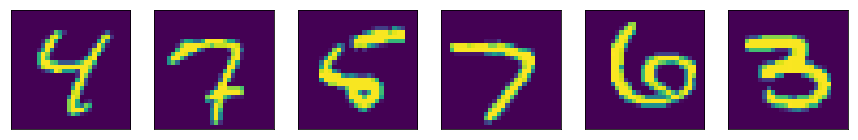

In [0]:
def show_images(image, n_row):
    for _ in range(n_row):  
        index=np.random.choice(100, 6)
        images =image.numpy()[index]    
        plt.figure(figsize=(15,90))    
        for a in range(161, 167):
            plt.subplot(a) # subplot(161)은 1행 6열의 1번째 칸을 의미합니다.
            plt.imshow(images[a-161], plt.cm.gray) # 각 subplot에 이미지를 한장씩 출력하도록 합니다.
            plt.xticks([]) # x축을 출력하지 않습니다.
            plt.yticks([]) # y축을 출력하지 않습니다.
        plt.show()  
        

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)


for i, (image,_) in enumerate(testDataLoader):
    show_images(denorm(image.squeeze()), 3)
    break

## Discriminator, Generator

![image.png](attachment:image.png)

In [0]:
"""
Discriminator를 선언해줍니다. Binary Cross Entropy Loss를 사용하기 위해서는 마지막에 Sigmoid 함수를 추가해줘야 합니다.
Discriminator에서는 이미지가 Real인지 Fake인지를 판단합니다.
"""
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, ?)
        self.fc2 = nn.Linear(256, ?)
        self.fc3 = nn.Linear(256, 1)
    
    def forward(self, x):
        out = F.leaky_relu(self.fc1(x), 0.2) # Discriminator에서는 leaky relu를 사용하는 경우가 많습니다.
        out = F.leaky_relu(self.fc2(out), 0.2)
        out = ?(self.fc3(out)) # Sigmoid 함수를 사용해야 합니다.
        
        return out

In [0]:
"""
Generator를 선언해줍니다.
Generator에서는 Discriminator를 속일 수 있는 Fake Image를 생성합니다.
"""
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(64, ?)
        self.fc2 = nn.Linear(256, ?)
        self.fc3 = nn.Linear(256, ?) # Generator의 마지막 Output의 크기는?? Hint : MNIST는 28x28x1
        
    def forward(self, x):
        out = F.relu(self.fc1(x)) # Generator에서는 relu를 사용하는 경우가 많습니다.
        out = F.relu(self.fc2(out))
        out = ?(self.fc3(out)) # tanh 함수를 사용해야 합니다.
        
        return out

In [0]:
# Discriminator와 Generator를 선언
D = Discriminator()
G = Generator()

if torch.cuda.is_available():
    D.cuda()
    G.cuda()

## Train Function

In [0]:
def train_network(D, G, trainloader):
    # Binary cross entropy loss and optimizer
    criterion = nn.BCELoss()
    d_optimizer = optim.Adam(D.parameters(), lr=0.0003)
    g_optimizer = optim.Adam(G.parameters(), lr=0.0003)
    
    for epoch in range(100):
        for i, (images, _) in enumerate(trainloader):
            # Build mini-batch dataset
            batch_size = images.size(0)
            images = to_var(images.view(?, ?)) # Hint : Linear를 사용하기 위해서는 Batch size를 제외하고, 나머지를 Vector형태로 만들어야합니다.

            # Create the labels which are later used as input for the BCE loss
            real_labels = to_var(torch.ones(batch_size))
            fake_labels = to_var(torch.zeros(batch_size))

            #============= Train the discriminator =============#
            # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
            # Second term of the loss is always zero since real_labels == 1
            outputs = D(images)
            d_loss_real = criterion(outputs, real_labels) # Discriminator가 real image를 1(Real)로 예측하도록 학습
            real_score = outputs

            # Compute BCELoss using fake images
            # First term of the loss is always zero since fake_labels == 0
            z = to_var(torch.randn(batch_size, 64))
            fake_images = G(z)
            outputs = D(fake_images)
            d_loss_fake = criterion(outputs, fake_labels) # Discriminator가 fake image를 0(Fake)으로 예측하도록 학습
            fake_score = outputs

            # Backprop + Optimize
            d_loss = d_loss_real + d_loss_fake
            D.?
            d_loss.?
            d_optimizer.?

            #=============== Train the generator ===============#
            # Compute loss with fake images
            z = to_var(torch.randn(batch_size, 64))
            fake_images = G(z)
            outputs = D(fake_images)

            # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
            # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
            g_loss = criterion(outputs, real_labels) # Generator에서 생성한 fake image가 Discriminator에서 1(Real)로 예측하도록 학습

            # Backprop + Optimize
            D.?
            G.?
            g_loss.?
            g_optimizer.?

            if (i+1) % 300 == 0:
                print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f' 
                      %(epoch, 200, i+1, 600, d_loss.item(), g_loss.item(), real_score.data.mean(), fake_score.data.mean()))
            if (i+1) % 300 == 0:
                fixed_z = to_var(torch.randn(batch_size, 64))
                G = test(G, fixed_z)

## Test Function

In [0]:
def test(G, fixed_z):
    G.eval()
    fake_images = G(fixed_z).view(-1, 28, 28)
    fake_images = (fake_images+1)/2
    images_to_show = fake_images.data.cpu().squeeze().numpy()
    images_row = images_to_show[:6] 

    plt.figure(figsize=(10,60))
    for a in range(161, 167):    
        plt.subplot(a)
        plt.imshow(images_row[a-161], plt.cm.gray)
        plt.xticks([])
        plt.yticks([])    
    plt.show() 

    G.train()
    return G

/home/sunghyun/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch [0/200], Step[300/600], d_loss: 0.2302, g_loss: 2.6643, D(x): 0.96, D(G(z)): 0.17


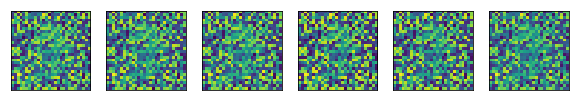

Epoch [0/200], Step[600/600], d_loss: 3.8352, g_loss: 1.1526, D(x): 0.13, D(G(z)): 0.63


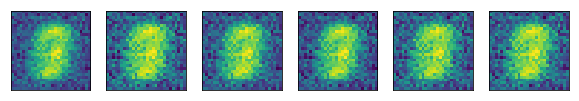

Epoch [1/200], Step[300/600], d_loss: 1.2836, g_loss: 1.9268, D(x): 0.59, D(G(z)): 0.42


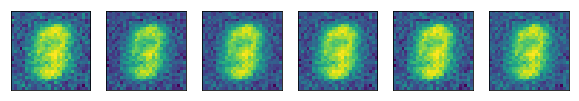

Epoch [1/200], Step[600/600], d_loss: 0.8165, g_loss: 1.7566, D(x): 0.64, D(G(z)): 0.28


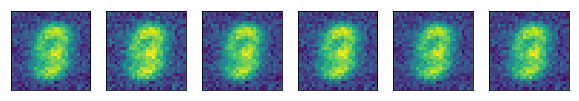

Epoch [2/200], Step[300/600], d_loss: 0.9451, g_loss: 1.3495, D(x): 0.64, D(G(z)): 0.38


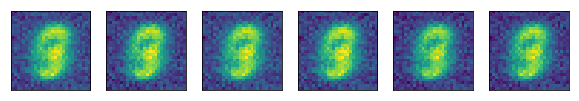

Epoch [2/200], Step[600/600], d_loss: 0.2688, g_loss: 3.0534, D(x): 0.89, D(G(z)): 0.10


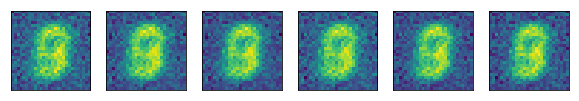

Epoch [3/200], Step[300/600], d_loss: 0.6295, g_loss: 2.0851, D(x): 0.81, D(G(z)): 0.24


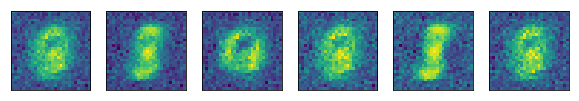

Epoch [3/200], Step[600/600], d_loss: 0.9312, g_loss: 1.4917, D(x): 0.71, D(G(z)): 0.36


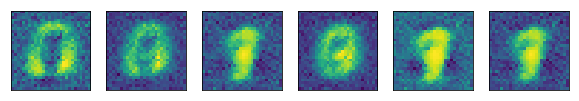

Epoch [4/200], Step[300/600], d_loss: 0.6270, g_loss: 3.4106, D(x): 0.78, D(G(z)): 0.15


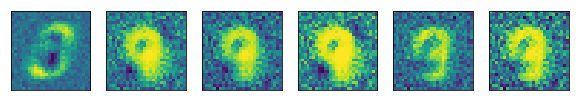

Epoch [4/200], Step[600/600], d_loss: 0.6750, g_loss: 2.5968, D(x): 0.81, D(G(z)): 0.30


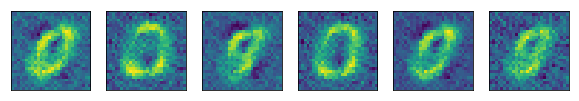

KeyboardInterrupt: 

In [0]:
train_network(D, G, trainDataLoader)

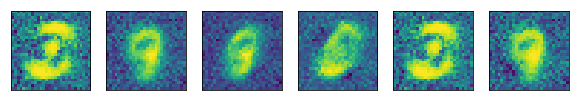

In [0]:
fixed_z = Variable(torch.randn(6,64)).cuda()
_ = test(G, fixed_z)

In [0]:
# Save the trained parameters 
torch.save(G.state_dict(), './model/gan_generator.pkl')
torch.save(D.state_dict(), './model/gan_discriminator.pkl')